# Feature Qualitätsmodell mit der DIM-Toolbox

Ziel des Tutorials ist den Workflow zur Identifikation von Feature-Qualitätsmodellen für den Spritzgießprozess mit der DIM-Toolbox zu veranschaulichen.

Die für das Modelltraining (Schätzung der Modellparameter) und die Modellvalidierung verwendeten Daten wurden im Rahmen eines umfangreichen Versuchsplanes erhoben. Der Trainingsdatensatz umfasst die Daten von 2105 Produktionszyklen, der Validierungsdatensatz umfasst die Daten von 548 Produktionszyklen.

In [10]:
import pickle as pkl
import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, "/home/alexander/GitHub/DigitalTwinInjectionMolding/")
sys.path.insert(0, 'E:/GitHub/DigitalTwinInjectionMolding/')

from DIM.miscellaneous.PreProcessing import LoadFeatureData,LoadSetpointData,MinMaxScale
from DIM.models.model_structures import Static_MLP
from DIM.optim.param_optim import ModelTraining, static_mode
from DIM.optim.common import BestFitRate

Spezifiziere Pfad zur Datenbasis und welche Chargen für Modellbildung und -validierung verwendet werden sollen 

In [2]:
path = 'E:/GitHub/DigitalTwinInjectionMolding/data/Versuchsplan/normalized/'
charges = list(range(1,275))
split = 'process' 

Spezifiziere Ein- und Ausgangsgrößen für Prozess- und Qualitätsmodell

In [ ]:
u_label_q = ['T_wkz_0', 'T_wkz_max', 't_Twkz_max', 'T_wkz_int', 'p_wkz_max',
'p_wkz_int', 'p_wkz_res', 't_pwkz_max']

y_label_q = ['Durchmesser_innen']

Die Funktion LoadFeatureData() berechnet aus den Prozessgrößen jedes Spritzgießzykluses teilt die abgelegten Daten in Trainings- und Validierungsdaten ein

In [3]:
data_train,data_val = LoadFeatureData(path,charges,split)

Es ist insbesondere bei der Verwendung Neuronaler Netze zweckmäßig, die Daten auf das Intervall [-1,1] zu skalieren, das geschieht mittels der Funktion MinMaxScale()

In [4]:
data_train,minmax = MinMaxScale(data_train,u_label_q+u_label_p+y_label_q)
data_val,_ = MinMaxScale(data_val,u_label_q+u_label_p+y_label_q,minmax)

Ein Neuronales Netz, welches Eingangsgrößen statisch auf Ausgangsgrößen abbildet ist Static_MLP. Bei der Erzeugung einer Instanz der Klasse Static_MLP müssen einige Parameter festgelegt werden:

| Parameter | Typ | Erläuterung |
| --- | --- | :-- |
|dim_u : |int |Anzahl an Modelleingängen |
|dim_hidden | int | Anzahl der Modellausgänge |
|u_label| list of str |Namen der Eingangsgrößen, muss mit den Spaltenüberschriften in data_train, data_val übereinstimmen|
|y_label| list of str |Namen der Ausgangsgrößen, muss mit den Spaltenüberschriften in data_train, data_val übereinstimmen|
|name | str | Name des Modells, wird verwendet, um Modellparameter eindeutig zu identifizieren und bspw. von den Parametern anderer Instanzen der gleichen Klasse zu unterscheiden|
|init_proc | str | Prozedur, die bei der Initialisierung der Modellparameter angewendet werden soll. Implementiert sind 'random', 'xavier' und 'he'|


In [5]:
model_q = Static_MLP(dim_u=8, dim_out=1, dim_hidden=4,u_label=u_label_q,
                    y_label=y_label_q,name='qual', init_proc='xavier')

Die Routine ModelTraining() erhält als Argument das zu optimierende Modell, Trainings- und Validierungsdaten, wie oft das Optimierungsproblem neu initialisiert und gelöst werden soll (nichtlineares Optimierungsproblem) sowie den Modus der Modellauswertung:

| Parameter | Typ | Erläuterung |
| --- | --- | :-- |
|model : | DIM.models | Zu optimierendes Modell |
|data_train | pd.DataFrame | Trainingsdaten mit Beobachtungen in den Zeilen und Eingangs- / Ausgangsgrößen in den Spalten |
|data_val| pd.DataFrame | Trainingsdaten mit Beobachtungen in den Zeilen und Eingangs- / Ausgangsgrößen in den Spalten |
|initializations| int | Anzahl der Multistarts, i.e. wie oft die Parameter zufällig neu initialisiert und das Optimierungsproblem von vorne gelöst werden soll|
|p_opts | dict | printing Optionen für CasADi, siehe https://web.casadi.org/docs/ |
|s_opts | dict | An IPOPT zu übergebende Parameter, siehe https://coin-or.github.io/Ipopt/OPTIONS.html |
|mode | str | Art der Modellauswertung, es wird unterschieden zwischen 'parallel', 'static' und 'series'|

Hier wird aus Zeitgründen ein fertiges Optimierungsergebnis geladen.

In [6]:
# result_q = ModelTraining(model_q,data_train,data_val,initializations=5,
#                           p_opts=None,s_opts=None,mode='static')

result_q = pkl.load(open('results_q_feature_stationary.pkl','rb'))


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Validation loss: 2264.23
Validation loss: 531.177
Validation loss: 188.667
Validation loss: 105.357
Validation loss: 62.8812
Validation loss: 40.04
Validation loss: 38.0657
Validation loss: 34.0897
Validation loss: 31.2243
Validation loss: 31.1227
Validation loss: 29.8901
Validation loss: 28.5176
Validation loss: 28.1076
Validation loss: 27.6742
Validation loss: 27.5229
Validation loss: 26.6852
Validation loss: 26.6155
Validation loss: 26.3767
Validation loss: 25.1965
Validation loss: 24.9045
Validation loss: 24.7933
Validation loss: 24.591
Validation loss: 24.4904
      solver  :   t_proc      (avg)   t_

Für gewöhnlich müssen einige Multistarts ausgeführt werden (mindestens 10) für dieses Tutorial wird aus Zeitgründen nur ein einziger Optimierungsdurchlauf durchgeführt

ModelTraining() gibt einen Pandas DataFrame zurück. Dieser enthält den Wert der Kostenfunktion des Modells jeweils auf den Trainings- und Validierungsdaten sowie die zugehörigen Modellparameter. Die Instanz der Klasse Static_MLP selbst ist unverändert. Die neuen Parameter müssen dem Modell erst noch zugewiesen werden: 

In [7]:
model_q.Parameters = result_q.loc[0]['params_val']

Das Modell mit den optimierten Parametern kann nun bspw. auf den Validerungsdaten (oder Daten des laufenden Betriebs) ausgewertet werden. Die Funktion static_mode() wertet ein statisches Modell auf einem gegebenen Datensatz aus.

In [8]:
_,prediction_q = static_mode(model_q,data_val)

Die Bauteilqualität prediction_q wurde nun nur basierend auf den aus den Prozessgrößen ermittelten Features ermittelt.

Um die Modellgüte zu beurteilen kann die Best Fit Rate berechnet werden:

In [ ]:
print(BestFitRate(data_val[y_label_q].values, prediction_q[y_label_q].values))

Durch Gegenüberstellung der bekannten wahren Bauteilqualität mit der prädizierten Bauteilqualität kann das Ergebnis visualisiert werden:

(1.0, 50.0)

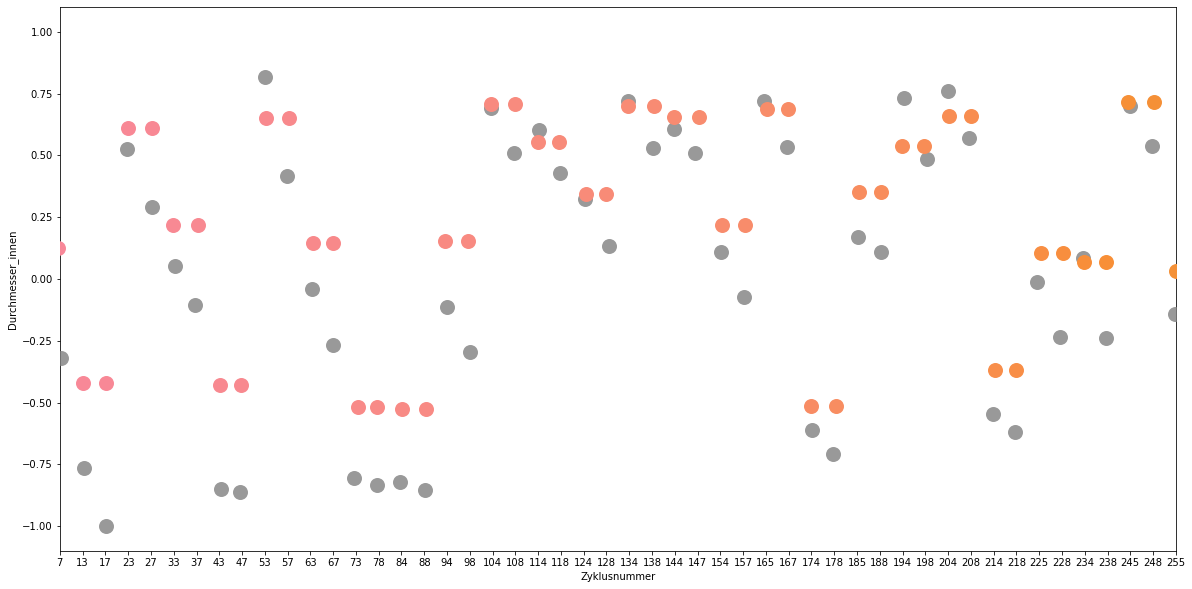

In [12]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.stripplot(x=data_val.index,y=data_val[y_label_q[0]],color='grey',
              alpha=.8,size=15,ax=ax)
sns.stripplot(x=prediction_q.index,y=prediction_q[y_label_q[0]],
              size=15,ax=ax)
ax.set_xlim([1,50]) 